# Задание — Распространение и эпидемии в сетях


In [12]:
import networkx as nx
from tqdm.notebook import trange
import numpy as np
from matplotlib.animation import FuncAnimation
from scipy.optimize import minimize
from scipy import integrate
from IPython.display import HTML
from zlib import adler32
import matplotlib.pyplot as plt

### Задание 1. Метод Эйлера (0 баллов)

Метод Эйлера представляет собой простую численную процедуру решения обыкновенных дифференциальных уравнений (ОДУ) с заданными начальными значениями. Например, если мы хотим решить уравнение

$$dx/dt = \sin(x)$$

с начальным значением $x = x_0$, мы можем заменить $dx = \Delta x = x_{i+1} - x_{i}$ и $dt = \Delta t$, поэтому мы получаем

$$\frac{x_{i+1} - x_i}{\Delta t} = \sin(x)$$ 
$$x_{i+1} = x_i + \sin(x)\Delta t$$

Let $\Delta t = 0.1$, и тогда мы можем решить уравнение, используя эту итеративную форму, следующим образом

In [14]:
def solve_sinx(x0, dt, k):
    x = x0
    solution = [x0]
    for _ in range(k):
        dx = np.sin(x) * dt
        x = x + dx
        solution.append(x)
    return solution

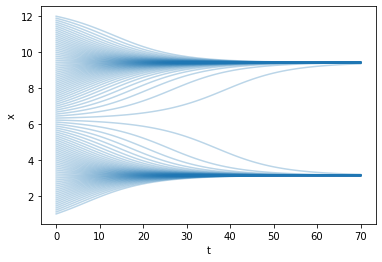

In [15]:
dt = 0.1
for x0 in np.linspace(1, 12, 100):
    solution = solve_sinx(x0, dt, 70)
    plt.plot(solution, c='tab:blue', alpha=0.3);
plt.xlabel('t')
plt.ylabel('x')
plt.show()

Предположим, что мы хотим решить знаменитую хаотическую систему Лоренца:

$$
\begin{cases}
\frac{dx}{dt} = \sigma(y-x)\\
\frac{dy}{dt} = x(\rho - z) - y\\
\frac{dz}{dt} = xy - \beta z\\
\end{cases}
$$

с параметрами $\rho = 28$, $\sigma = 10$, $\beta = 8/3$ и начальными значениями $x = y = z = 10$.

Напишите функцию `lorenz` , которая принимает начальные значения, параметры, приращение времени `dt`, количество итераций `k` и возвращается np.array с решением вида `[[x0, y0, z0], [x1, y1, z1], ...]` так что количество строк `k+1`.

In [16]:
def lorenz(x0, y0, z0, rho, sigma, beta, dt, k):
    # YOUR CODE HERE
    output = np.zeros((k + 1, 3))
    output[0][0], output[0][1], output[0][2] = x0, y0, z0

    for i in range(1, k):        
        x = output[i - 1][0]
        y = output[i - 1][1]
        z = output[i - 1][2]
        
        output[i][0] = x + (sigma * (y - x)) * dt
        output[i][1] = y + (x * (rho - z) - y) * dt
        output[i][2] = z + (x * y - beta * z) * dt

    return output

In [17]:
sim = lorenz(10., 10., 10., 28., 10., 8/3, 0.01, 8000-1)
assert sim.shape == (8000, 3)
assert np.all(sim[0] == [10, 10, 10])
assert np.all(sim[1].round(2) == [10., 11.7, 10.73])
assert np.all(sim[2].round(2) == [10.17, 13.31, 11.62])
assert adler32(str(sim[3].round(2)[0]).encode()) == 48496892

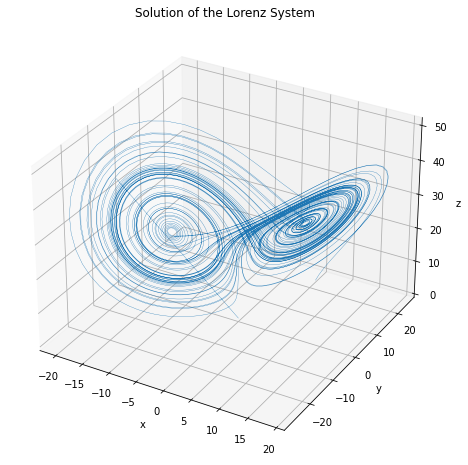

In [18]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')
xs, ys, zs = sim[:, 0], sim[:, 1], sim[:, 2]
ax.plot(xs, ys, zs, lw=0.3)
plt.title('Solution of the Lorenz System')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

### Задание 2. Модель SI (0 баллов)

Рассмотрим простую модель эпидемии — модель SI. S — восприимчивый, I — заразный. Изначально у нас всего несколько инфицированных, а все остальные восприимчивы. Затем некоторые восприимчивые люди заражаются с уровнем заражения $beta$. Модель определяется следующим образом:

Динамическая форма

$$S \underset{\beta SI}{\to} I$$

Форма уравнения

$$\frac{dI}{dt} = \beta \frac{S}{N}I$$

$$S + I = N$$

где $N$ это общая численность населения.

Напишите функцию `si_epidemic` которое берет общее население `total`, количество инфицированных людей `I0`, уровень инфицирования `beta`, время инфицирования `dt`, кол-во итераций `k` и возвращает np.array с решением вида `[[S0, I0], [S1, I1], ...]` так что количество строк k+1.

In [19]:
def si_epidemic(total, I0, beta, dt, k):
    # YOUR CODE HERE
    output = [[total - I0, I0]]
    S, I = output[-1]
    for _ in range(k):
        dI = beta * S / total * I * dt
        I += dI
        S -= dI
        output.append([S, I])
    return np.array(output)

    raise NotImplementedError()

In [20]:
solution = si_epidemic(total=1000, I0=1, beta=0.3, dt=0.5, k=130-1)
assert solution.shape == (130, 2)
assert np.all(solution[0] == [999, 1])
assert np.all(solution[10].round(2) == [995.97, 4.03])
assert np.all(solution[-1].round(2) == [0, 1000])
assert adler32(str(solution[100].round(2)[0]).encode()) == 32047304

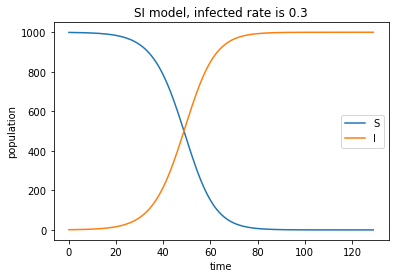

In [21]:
plt.plot(solution)
plt.legend(['S', 'I'])
plt.title('SI model, infected rate is 0.3')
plt.xlabel('time')
plt.ylabel('population')
plt.show()

Давайте посмотрим на график эпидемической динамики с той же установкой, но $\beta = 0.1$.

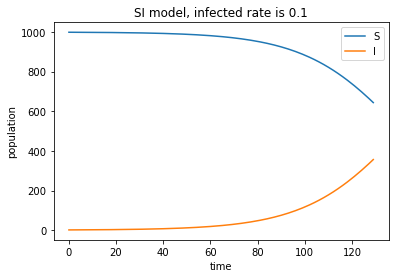

In [22]:
solution = si_epidemic(total=1000, I0=1, beta=0.1, dt=0.5, k=130-1)
plt.plot(solution)
plt.legend(['S', 'I'])
plt.title('SI model, infected rate is 0.1')
plt.xlabel('time')
plt.ylabel('population')
plt.show()

### Задание 3. SIR модель (2 балла)

Следующая модель SIR. S — восприимчивые, I — заразные, R — переболевшие. Изначально у нас всего несколько инфицированных, а остальные восприимчивы. Затем некоторые восприимчивые люди заражаются с коэффициентом заражения $beta$, а некоторые инфицированные выздоравливают с коэффициентом выздоровления $\gamma$. Шансов заразиться после выздоровления нет. Модель определяется следующим образом:

Динамическая форма:

$$S \underset{\beta SI}{\to} I \underset{\gamma I}{\to} R$$

Форма уравнения (в долях населения)

$$\begin{cases}
ds/dt = -\beta si\\
di/dt = \beta si - \gamma i\\
dr/dt = \gamma i\\
s+i+r = 1
\end{cases}$$

Напишите функцию `sir_epidemic`, которая принимает начальную пропорцию `s0`, `i0`, `r0`, уровень заражения `beta`, скорость восстановления `gamma`, количество шагов `k` и увеличение времени `dt`. Функция возвращает np.array формы `(k+1, 3)` с `s`, `i`, `r` пропорциями для каждого шага. Первая строка содержит начальную пропорцию.

In [23]:
def sir_epidemic(s0, i0, r0, beta, gamma, k, dt):
    # YOUR CODE HERE
    output = [[s0, i0, r0]]
    s, i, r = output[-1]
    for _ in range(1, k + 1):
        ds = - beta * s * i * dt
        di = (beta * s * i - gamma * i) * dt
        dr = gamma * i * dt
        s += ds
        i += di
        r += dr
        output.append([s, i, r])
    return np.array(output)

    raise NotImplementedError()

In [24]:
s0, i0, r0 = 0.99, 0.01, 0
beta, gamma = 0.6, 0.1
dt = 1
epidemic = sir_epidemic(s0, i0, r0, beta, gamma, 80, dt)
assert epidemic.shape == (81, 3)
assert np.all(epidemic[0] == [0.99, 0.01, 0.  ])
assert np.all(epidemic[5].round(2) == [0.92, 0.07, 0.01])
assert np.all(epidemic[80].round(2) == [0, 0, 1])
assert adler32(str(epidemic[10].round(2)[1]).encode()) == 32112840

Здесь также находится критическая точка для базового репродукционного числа $R_0 = \beta / \gamma$

* If $R_0 > 1$: Endemic State,  $r(+\infty) \to 1$
* If $R_0 < 1$: Disease-free State, $r(+\infty) \to \text{const}$

где $r(t)$ доля выздоровевших на момент времени $t$.

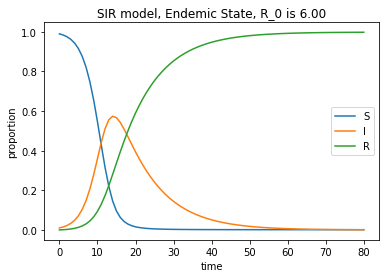

In [25]:
plt.plot(epidemic)
plt.legend(['S', 'I', 'R']);
plt.title('SIR model, Endemic State, R_0 is {:.2f}'.format(beta/gamma))
plt.xlabel('time')
plt.ylabel('proportion')
plt.show()

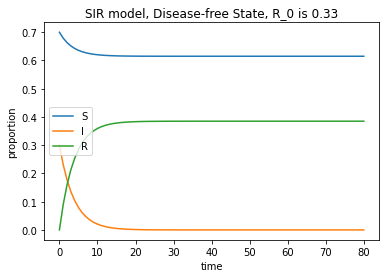

In [26]:
s0, i0, r0 = 0.7, 0.3, 0.
dt = 1
beta, gamma = 0.1, 0.3
epidemic = sir_epidemic(s0, i0, r0, beta, gamma, 80, dt)
plt.plot(epidemic)
plt.legend(['S', 'I', 'R']);
plt.title('SIR model, Disease-free State, R_0 is {:.2f}'.format(beta/gamma))
plt.xlabel('time')
plt.ylabel('proportion')
plt.show()

### Задание 4. Распространение в сетях (2 балла)

Процесс диффузии — это модель распространения, в которой значения узлов $\phi$ (say, 'heat') распространяться за пределы зоны высокой концентрации. Рассмотрим диффузию на сетке размером 20x20. Пусть имеется подсетка 3x3 с теплотворной способностью 3 и подсетка 7x5 с теплотворной способностью 1. Все остальные узлы имеют значение 0. Начальное тепловое значение равно $\phi_0$.

In [27]:
phi_map = np.zeros((20, 20))
phi_map[1:4, 1:4] = 3
phi_map[10:15, 8:15] = 1
phi0 = phi_map.flatten()

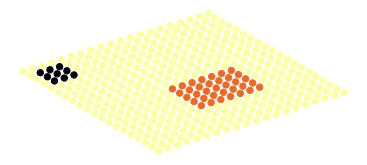

In [28]:
plt.figure(figsize=(7*0.7, 3*0.7))
gridG = nx.grid_graph((20, 20))
nx.draw_kamada_kawai(
    gridG,
    cmap=plt.cm.inferno_r,
    vmin=0, vmax=3,
    width=0,
    node_size=40,
    node_color=phi0)

Создайте симуляцию диффузии на основе этого уравнения диффузии

$$\frac{d\phi}{dt} = -CL\phi$$

где $L$ является граф Laplacian.

Напишите функцию `next_phi`, которая принимает матрицу смежности `A`, np.array с предыдущими значениями тепла `phi`, константа `C` и увеличение времени `dt`. Функция возвращает np.array со следующими значениями тепла.

In [29]:
def next_phi(A, phi, C, dt):
    # YOUR CODE HERE
    L = np.diag(np.sum(A, axis=0)) - A
    d_Phi = -1 * C * L @ phi
    phi_next = phi + d_Phi * dt
    return phi_next

    raise NotImplementedError()

In [30]:
A = nx.to_numpy_array(gridG)
C = 0.1
dt = 2
phi = next_phi(A, phi0, C, dt)
assert phi.shape == (400,)
assert phi.sum() == phi0.sum()
assert phi.std() < phi0.sum()
assert round(phi[20:25].sum(), 4) == 7.2

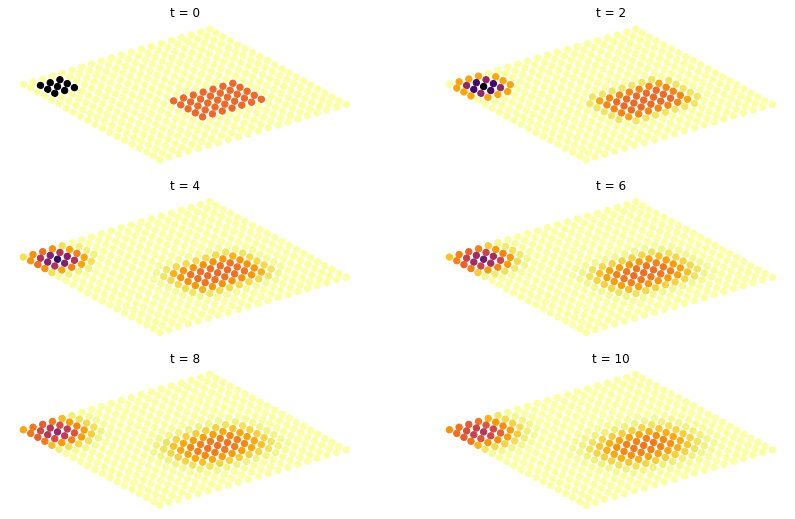

In [31]:
plt.figure(figsize=(7*2, 3*3))

phi = phi0
for i in range(6):
    plt.subplot(3, 2, i+1)
    gridG = nx.grid_graph((20, 20))
    nx.draw_kamada_kawai(
        gridG,
        cmap=plt.cm.inferno_r,
        vmin=0, vmax=3,
        width=0,
        node_size=40,
        node_color=phi)
    plt.title('t = {}'.format(i*dt))
    phi = next_phi(A, phi, C, dt)
phi12 = phi

Мы можем запускать моделирование шаг за шагом столько, сколько нам нужно, но, к счастью, есть аналитическое решение.

$$\phi(t) = \sum_k a_k(t) v_k = \sum_k a_k(0) e^{-C\lambda_k t} v_k$$

где $a_k(t) = \phi(t)^T v_k$ и $v_k$ является k-м наименьшим собственным вектором Laplacian.

Напишите функцию `phi_t`, которая принимает матрицу смежности `A`, np.array с начальными значениями тепла `phi0`, константа `C` и момент времени `t`. Функция возвращает np.array со значениями тепла в момент времени `t`. Используйте `np.linalg.eigh` или `scipy.linalg.eigh` для симметричной матрицы.

In [32]:
def phi_t(A, phi0, C, t):
    # YOUR CODE HERE
    
    L = np.diag(np.sum(A, axis=0)) - A
    eigval, eigvec = np.linalg.eigh(L)
    phi = np.zeros(phi0.shape)
    it = np.nditer(eigval, flags=['f_index'])
    for val in it:
        vec = np.array(eigvec[:,it.index])
        a_k0 = phi0.T @ vec
        phi += a_k0 * np.exp(-1 * C * val * t) * vec
    return phi

    raise NotImplementedError()

In [33]:
assert phi_t(A, phi0, C, 0).shape == (400,)
assert round(np.linalg.norm(phi0 - phi_t(A, phi0, C, 0)), 4) == 0
assert round(np.linalg.norm(phi12 - phi_t(A, phi0, C, 12)), 4) < 0.4
assert len(np.unique(phi_t(A, phi0, C, 10000).round(4))) == 1
assert phi_t(A, phi0, C, 10000).round(4)[0] == phi0.sum() / len(phi0)

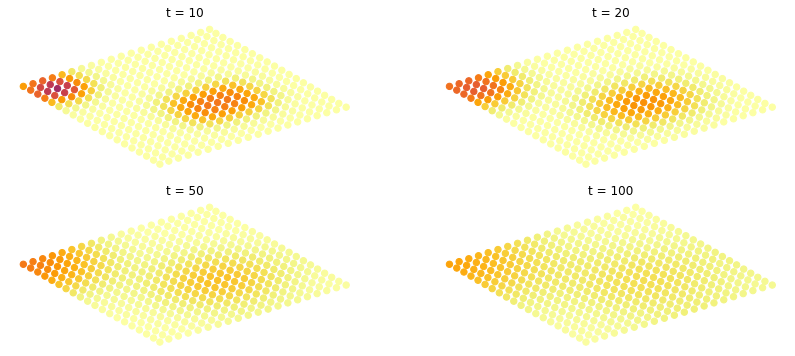

In [34]:
plt.figure(figsize=(7*2, 3*2))
i = 1
for t in [10, 20, 50, 100]:
    plt.subplot(2, 2, i)
    gridG = nx.grid_graph((20, 20))
    nx.draw_kamada_kawai(
        gridG,
        cmap=plt.cm.inferno_r,
        vmin=0, vmax=3,
        width=0,
        node_size=40,
        node_color=phi_t(A, phi0, C, t))
    plt.title('t = {}'.format(t))
    i += 1

### Задание 5. Модель SIS на сетях (0 баллов)

Рассмотрим модели эпидемий в сетях. Модель SIS описывается динамической формой

$$S \to_{\beta SI} I \to_{\gamma I} S$$

Для моделирования эпидемий в сетях нам необходимо использовать вероятностный подход. Во-первых, давайте определим функцию, которая дает нам случайную выборку доступных узлов с заданной вероятностью.

Функция `select_nodes`, которая берет np.array `vec`, где i-й элемент — это количество соседей, которые могут воздействовать на i-й узел с вероятностью `proba`. Например, `vec` может представлять количество зараженных соседей, скажем [0, 2, 1] и тогда вероятность - зараженный показатель $\beta$. Это означает, что у первого узла нет зараженных соседей, у второго — два зараженных соседа, у третьего — один зараженный сосед. Таким образом, второй узел имеет $(1 - (1-\beta)^2)$ вероятность заразиться.

In [35]:
def select_nodes(vec, proba):
    sample = np.random.rand(len(vec))
    res = sample < (1 - (1 - proba)**vec)
    return res.astype('int')

Давайте заразим несколько случайных узлов и смоделируем распространение эпидемии.

Напишите функцию `sis_networks`, которая берет граф `G`, np.array с начальным индикаторным вектором `S` где `S[i]` это 1, если i-й узел восприимчив, и 0, в противном случае (то же самое для `I`). Любой узел должен быть уязвимым или зараженным на любом этапе. Также функция принимает ставки `beta`, `gamma`, количество шагов `k`. Функция возвращает np.array формы `(k+1, 2, n)` где `n` это количество узлов. На i-м шаге матрица `result[i, :, :]` содержит индикатор `S` в первом столбце и `I` во-вторых.

_Hint: подсчитать количество зараженных соседей, use `I @ A * S`_

In [36]:
def sis_networks(G, S, I, beta, gamma, k):
    # YOUR CODE HERE
    A = nx.to_numpy_array(G)
    epidemic = []
    epidemic.append([S, I])
    for _ in range(k):
        dI = select_nodes(I @ A * S, beta) - select_nodes(I, gamma)
        I = I + dI
        S = 1 - I
        epidemic.append([S, I])
    return np.array(epidemic)
    
    raise NotImplementedError()

In [37]:
G = nx.barabasi_albert_graph(50, 3, seed=0)

I = np.zeros(len(G))
I[:3] = 1
S = 1 - I
beta = 0.2
gamma = 0.2

epidemic = sis_networks(G, S, I, beta, gamma, 100)
assert epidemic.sum() == 5050
assert epidemic.shape == (101, 2, 50)
assert (epidemic.sum(axis=1) == 1).sum() == 5050
sigma = 6.3853
mean = 16.0198
assert mean - 2*sigma < round(epidemic.sum(axis=2)[:, 0].mean(), 4) < mean + 2*sigma
sigma = 5.953
mean = 34.2178
assert mean - 2*sigma < round(epidemic.sum(axis=2)[:, 1].mean(), 4) < mean + 2*sigma

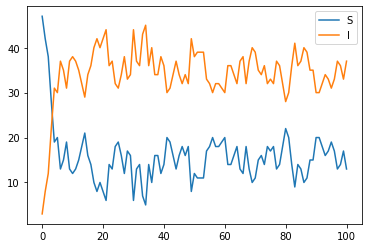

In [38]:
plt.plot(epidemic.sum(axis=2))
plt.legend(['S', 'I']);

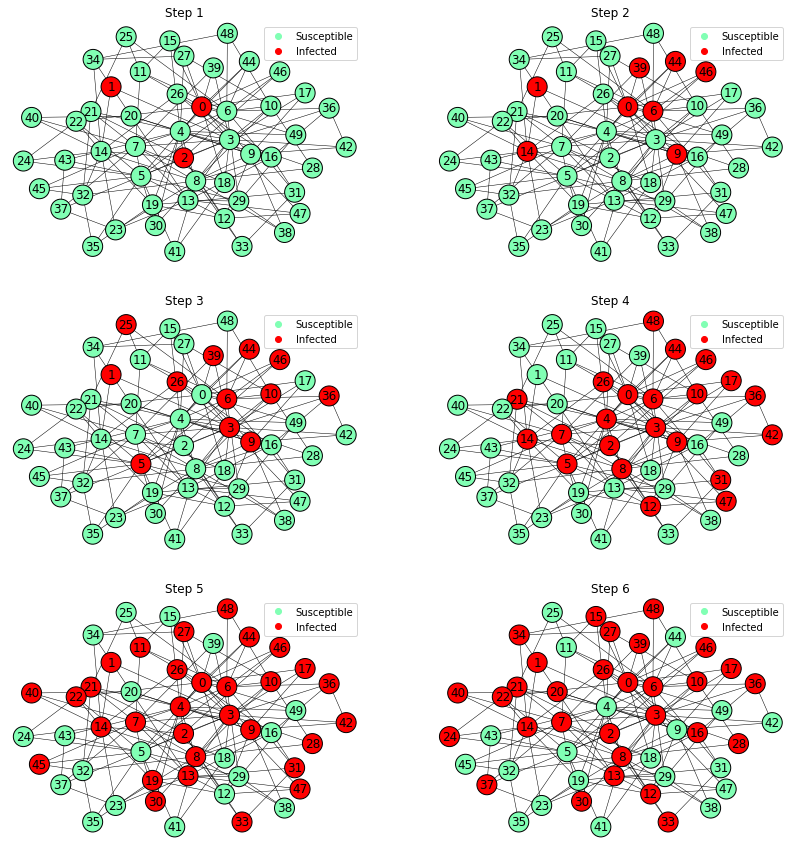

In [39]:
plt.figure(figsize=(7*2, 5*3))
pos = nx.kamada_kawai_layout(G)
i = 1
for S, I in epidemic[:6]:
    plt.subplot(3, 2, i)
    nodes = nx.draw_networkx_nodes(G, pos, 
            node_size=400,
            node_color=I+1, 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    nx.draw_networkx_edges(G, pos,
            width=0.5,
            node_size=400)
    nx.draw_networkx_labels(G, pos)
    plt.title('Step {}'.format(i))
    plt.legend(nodes.legend_elements()[0], ['Susceptible', 'Infected'])
    plt.axis('off')
    i += 1

### Задание 6. Модель SIRS на сетях (2 балла)

Давайте реализуем модель уровня узла SIRS.
$$S \to_{\beta SI} I \to_{\gamma I} R \to_{\delta R} S$$

Напишите функцию `sirs_networks`, которая берет граф `G`, np.array с начальным показателем `S` где `S[i]` равно 1, если i-й узел восприимчив, и 0 в противном случае (то же самое для `I` и `R`). Также функция принимает ставки `beta`, `gamma`, `delta`, количество шагов `k`. Функция возвращает np.array формы `(k+1, 3, n)` где `n` количество узлов. На i-м шаге матрица `result[i, :, :]` содержит индикатор `S` в первой колонке, `I` во второй, `R` в третьей.

In [46]:
def sirs_networks(G, S, I, R, beta, gamma, delta, k):
    # YOUR CODE HERE
    A = nx.to_numpy_array(G)
    epidemic = []
    epidemic.append([S, I, R])
    for _ in range(k):
        dSI = select_nodes(I @ A * S, beta)
        dIR = select_nodes(I, gamma)
        dRS = select_nodes(R, delta)
        
        dS = dRS - dSI
        dI = dSI - dIR
        dR = dIR - dRS
        
        I = I + dI
        S = S + dS
        R = R + dR
        epidemic.append([S.copy(), I.copy(), R.copy()])
    return np.array(epidemic)

    
    raise NotImplementedError()

In [47]:
G = nx.barabasi_albert_graph(40, 3, seed=0)
I = np.zeros(len(G))
I[:3] = 1
S = 1 - I
R = np.zeros(len(G))

beta = 0.1
gamma = 0.3
delta = 0.1

epidemic = sirs_networks(G, S, I, R, beta, gamma, delta, 200)
assert epidemic.shape == (201, 3, 40)
assert (epidemic.sum(axis=1) == 1).sum() == 8040
assert (epidemic[200].sum(axis=1) == [40, 0, 0]).sum() == 3

for k in range(6):
    for node in G.nodes:
        if epidemic[k, 0, node] > epidemic[k+1, 0, node]:
            assert epidemic[k+1, 1, node] == 1
            neighbors = np.array([n for n in G.neighbors(node)])
            assert epidemic[k, 1][neighbors].sum()
        elif epidemic[k, 1, node] > epidemic[k+1, 1, node]:
            assert epidemic[k+1, 2, node] == 1
        elif epidemic[k, 2, node] > epidemic[k+1, 2, node]:
            assert epidemic[k+1, 0, node] == 1

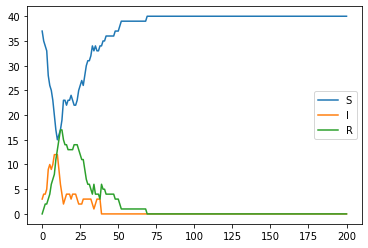

In [48]:
plt.plot(epidemic.sum(axis=2))
plt.legend(['S', 'I', 'R']);

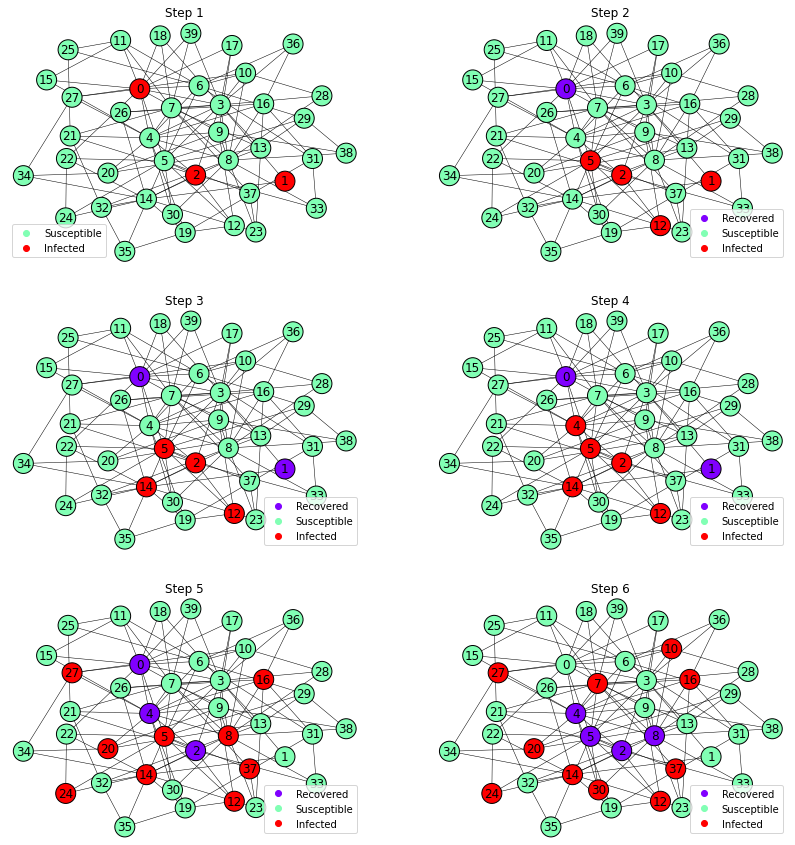

In [49]:
plt.figure(figsize=(7*2, 5*3))
pos = nx.kamada_kawai_layout(G)
i = 1
for S, I, R in epidemic[:6]:
    plt.subplot(3, 2, i)
    nodes = nx.draw_networkx_nodes(G, pos, 
            node_size=400,
            node_color=(S + I*2), 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    nx.draw_networkx_edges(G, pos,
            width=0.5,
            node_size=400)
    nx.draw_networkx_labels(G, pos)
    plt.title('Step {}'.format(i))
    if len(nodes.legend_elements()[0]) == 2:
        plt.legend(
            nodes.legend_elements()[0], 
            ['Susceptible', 'Infected'])
    else:
        plt.legend(
            nodes.legend_elements()[0], 
            ['Recovered', 'Susceptible', 'Infected'])
    plt.axis('off')
    i += 1

Мы также можем смоделировать «вторые волны», используя параметр дельта.

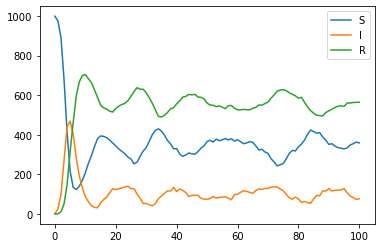

In [50]:
G = nx.barabasi_albert_graph(1000, 3, seed=0)

I = np.zeros(len(G))
I[0] = 1
S = 1 - I
R = np.zeros(len(G))

epidemic = sirs_networks(G, S, I, R, 0.3, 0.4, 0.07, 100)
plt.plot(epidemic.sum(axis=2))
plt.legend(['S', 'I', 'R']);

### Граф Эрдоша-Реньи

Эта часть задания посвящена моделям распространения влияния: линейной пороговой модели и независимой каскадной модели. Есть много применений этих типов моделей, например:
* Возникновение политического движения в нестабильном обществе
* Эффекты «сарафанного радио»: когда у нас есть доступ к большому количеству информации, например, когда мы оцениваем новые технологии, рискованные финансовые активы или кандидатов на работу, нам часто не хватает возможности разобраться в ней; следовательно, мы полагаемся на советы надежных друзей, коллег или советников.
* Влияние «вирусного маркетинга» на успех новых продуктов
* Внедрение медицинских и сельскохозяйственных инноваций
* Каскадные сбои в энергосистемах
* Принятие решения большинством голосов

Рассмотрим эти модели на ориентированном графе Эрдоша Реньи.

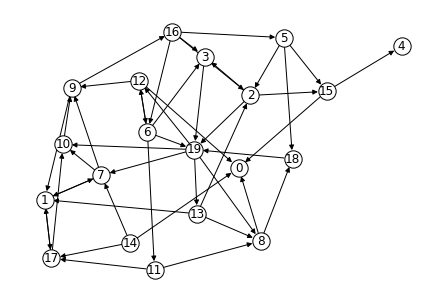

In [51]:
n = 20
G = nx.erdos_renyi_graph(n, 0.11, 0, True)

plt.figure(figsize=(6, 4))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=True, node_color='white', edgecolors='black')

### Задание 7. Линейная пороговая модель (0 баллов)

Линейная пороговая модель определяется следующим образом. Учитывая выбор порогов всех узлов и начальный набор активных узлов, процесс диффузии разворачивается детерминировано дискретными шагами: на шаге $t$,все узлы, которые были активны на этапе $t-1$ оставаться активным; более того, каждый в данный момент неактивный узел становится активным тогда и только тогда, когда
если общая доля его активных соседей не меньше порога узла.

напишите функцию `linear_threshold`, которая берет график, np.array `active_nodes` с нулями и единицами (если `active_nodes[i]` равно 1, то i-й узел активен), np.array of `thresholds`. Функция распространяет влияние и останавливается, когда модель перестает изменяться. Функция возвращает np.array с активными узлами на каждом шаге. Первый шаг — начальная активация, последний и предпоследний шаги одинаковы (мы хотим видеть, что распространение перестает меняться).

In [52]:
def linear_threshold(G, active_nodes, thresholds):
    # YOUR CODE HERE
    result =[active_nodes]
    current_active_nodes = active_nodes.copy()
    while True:
        active_nodes = current_active_nodes.copy()
        for n in G.nodes:
            if current_active_nodes[n] != 1:
                neighbors = [i for i in G.predecessors(n)]
                if  np.sum(active_nodes[neighbors])/len(neighbors) >= thresholds[n]:
                    current_active_nodes[n] = 1
        result.append(current_active_nodes.copy())
        if np.all(active_nodes == current_active_nodes):
            break
    return np.array(result)

In [54]:
np.random.seed(5)
active_nodes = np.zeros(n, 'int')
active_nodes[np.random.choice(np.arange(n), 2, False)] = 1
thresholds = np.random.uniform(0.5, 1, n)

sim = linear_threshold(G, active_nodes, thresholds)

assert sim.shape == (4, 20)
assert np.all(sim[0] == active_nodes)
assert np.all(sim[-1] == sim[-2])
assert sim[0, 4] == 0
assert sim[2, 4] == 1
assert sim[0, 3] == 0
assert sim[1, 15] == 1

<ipython-input-52-1f74c74a5442>:10: RuntimeWarning: invalid value encountered in long_scalars
  if  np.sum(active_nodes[neighbors])/len(neighbors) >= thresholds[n]:


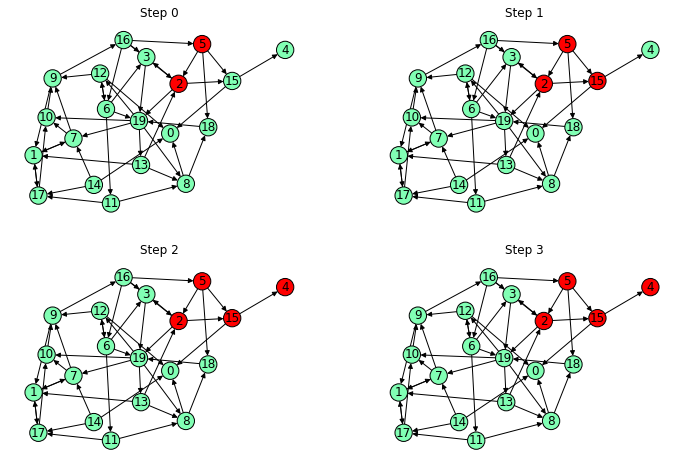

In [55]:
plt.figure(figsize=(6*2, 4*2))

for i, color in enumerate(sim):
    plt.subplot(2, 2, i+1)
    nx.draw(G, pos, with_labels=True, 
            node_color=color+1, 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    plt.title('Step {}'.format(i))
plt.show()

### Задание 8. Независимая каскадная модель (2 балла)

Следующий тип – независимая каскадная модель. Мы снова начинаем с начального набора активных узлов, и процесс разворачивается дискретными шагами в соответствии со следующим рандомизированным правилом. Когда узел $v$ сначала становится активным на шаге $t$, дается единственный шанс активировать каждого в данный момент неактивного соседа $w$; это удается с вероятностью $p_{v,w}$ — параметр системы — независимо от истории до сих пор. (Если $w$ имеет несколько вновь активированных соседей, их попытки следуют в произвольном порядке.) Если $v$ удается, то $w$ станет активным на шаге $t+1$; но независимо от того, удастся ли $v$, 
он не может предпринимать дальнейших попыток активировать $w$ на последующих шагах.

Напишите функцию `independent_cascade`, которая принимает граф, np.array active_nodes с нулями и единицами (если active_nodes[i] равен 1, то i-й узел активен), np.array с вероятностями распространения `prop_proba` для ребер по заказу `G.edges`. Функция распространяет влияние и останавливается, когда модель перестает изменяться. Функция возвращает np.array с активными узлами на каждом шаге. Первый шаг — начальная активация, последний и предпоследний шаги одинаковы (мы хотим, чтобы модель перестала меняться).

In [56]:
def independent_cascade(G, active_nodes, prop_proba):
    # YOUR CODE HERE
    for idx, edge in enumerate(G.edges):
        G[edge[0]][edge[1]]['prop'] = prop_proba[idx]
        G[edge[0]][edge[1]]['attempt'] = True
    result =[active_nodes]
    current_active_nodes = active_nodes.copy()
    while True:
        active_nodes = current_active_nodes.copy()
        for n in G.nodes:
            if current_active_nodes[n] == 1:
                for edge in G.edges(n):
                    if G[edge[0]][edge[1]]['attempt']:
                        G[edge[0]][edge[1]]['attempt'] = False
                        prop = G[edge[0]][edge[1]]['prop']
                        if np.random.rand() < prop:
                            current_active_nodes[edge[1]] = 1
        result.append(current_active_nodes.copy())
        if np.all(active_nodes == current_active_nodes):
            break
    return np.array(result)

    raise NotImplementedError()

In [57]:
np.random.seed(1)
active_nodes = np.zeros(20, 'int')
active_nodes[np.random.choice(np.arange(20), 2, False)] = 1
prop_proba = np.random.rand(len(G.edges))

sims = []
n_steps = []
for i in range(1000):
    sim = independent_cascade(G, active_nodes, prop_proba)
    sims.append(sim)
    n_steps.append(len(sim))
sigma = 1.9165
mean = 5.103
assert mean - 2*sigma < np.mean(n_steps) < mean + 2*sigma
sim = sims[n_steps.index(6)]
assert sim.shape == (6, 20)
assert np.all(sim[0] == active_nodes)
assert np.all(sim[-1] == sim[-2])
for i in range(1, 4):
    attempts = sim[i] - sim[i-1]
    new_active = sim[i+1] - sim[i]
    has_edge = False
    for j in np.argwhere(attempts == 1):
        for k in np.argwhere(new_active == 1):
            if G.has_edge(j[0], k[0]):
                has_edge = True
    assert has_edge

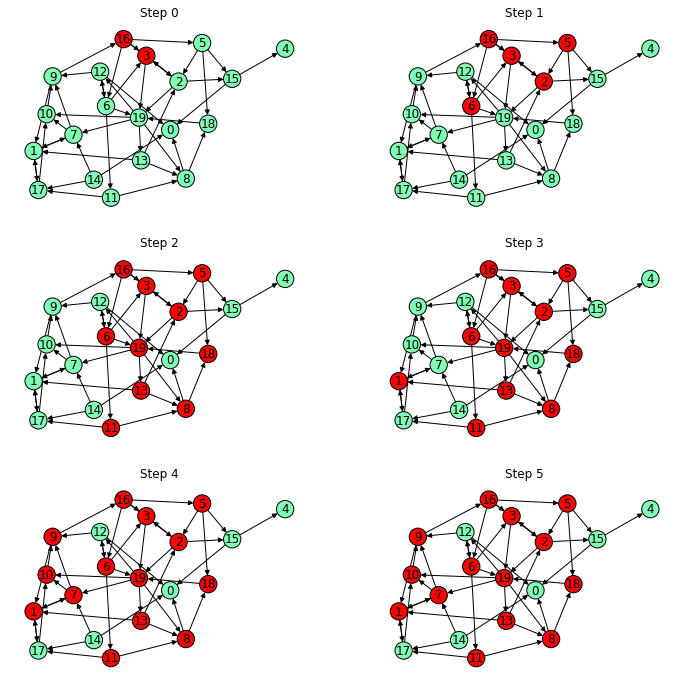

In [58]:
plt.figure(figsize=(6*2, 4*3))

for i, color in enumerate(sim):
    plt.subplot(3, 2, i+1)
    nx.draw(G, pos, with_labels=True, 
            node_color=color+1, 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    plt.title('Step {}'.format(i))
plt.show()

### Задание 9. Максимизация жадного влияния (2 балла)

Влияние — это ожидаемое количество активных узлов в конце процесса.

$$\sigma(A_0) = \mathbb E[|A_t|]$$

где $A_0$ является начальными активными узлами и $A_t$ это активные узлы в конце. Линейная пороговая модель является детерминированной, и тогда $E[|A_t|] = |A_t|$.

Задача максимизации влияния заключается в том, чтобы для заданного числа начальных активных узлов $k$ найти набор узлов, дающий максимальное влияние. Это NP-сложная задача, но ее полезное свойство заключается в том, что ее можно решить за полиномиальное время с помощью жадной оптимизации с гарантированной производительностью чуть выше 63%. Доказательства [here](https://theoryofcomputing.org/articles/v011a004/v011a004.pdf). Алгоритм:

1. Let $A_0 = \emptyset$
2. Для каждого узла $i$, рассчитать влияние $\sigma(A_0 \cup \{i\})$
3. Поместите узел с наибольшим влиянием в начальный активный набор $A_0 = A_0 \cup \{i\}$
4. Повторяйте 2-3, пока $|A_0| = k$

Напишите функцию `greedy_influence_max` ,которая берет граф, `thresholds` линейной пороговой модели, количество активных узлов `k` и вычисляет начальные активные узлы по жадному алгоритму. Функция возвращает np.array с нулями и единицами (если`active_nodes[i]` равно 1, то активен i-й узел).

In [59]:
def greedy_influence_max(G, thresholds, k):
    # YOUR CODE HERE
    active_nodes = np.zeros(np.size(G.nodes))
    while np.sum(active_nodes) < k:
        best_node = -1
        best_score = 0
        for v in G.nodes():
            if not active_nodes[v]:
                curr_active_nodes = active_nodes.copy()
                curr_active_nodes[v] = 1
                sigma = np.sum(linear_threshold(G, curr_active_nodes, thresholds)[-1])
                if sigma > best_score:
                    best_score = sigma
                    best_node = v
        active_nodes[best_node] = 1
    return active_nodes

    raise NotImplementedError()

In [62]:
n = 100
G = nx.erdos_renyi_graph(n, 0.07, 0, True)

np.random.seed(0)
active_nodes = np.zeros(n, 'int')
active_nodes[np.random.choice(np.arange(n), 2, False)] = 1
thresholds = np.random.uniform(0.1, 0.8, n)

best_active = greedy_influence_max(G, thresholds, 2)
assert best_active.shape == (100,)
assert best_active.sum() == 2
sim = linear_threshold(G, best_active, thresholds)
assert sim[-1].sum() > 21 * 0.63

Здесь та же модель, что и в линейной пороговой задаче, но с лучшим начальным активным набором.

<ipython-input-52-1f74c74a5442>:10: RuntimeWarning: invalid value encountered in double_scalars
  if  np.sum(active_nodes[neighbors])/len(neighbors) >= thresholds[n]:


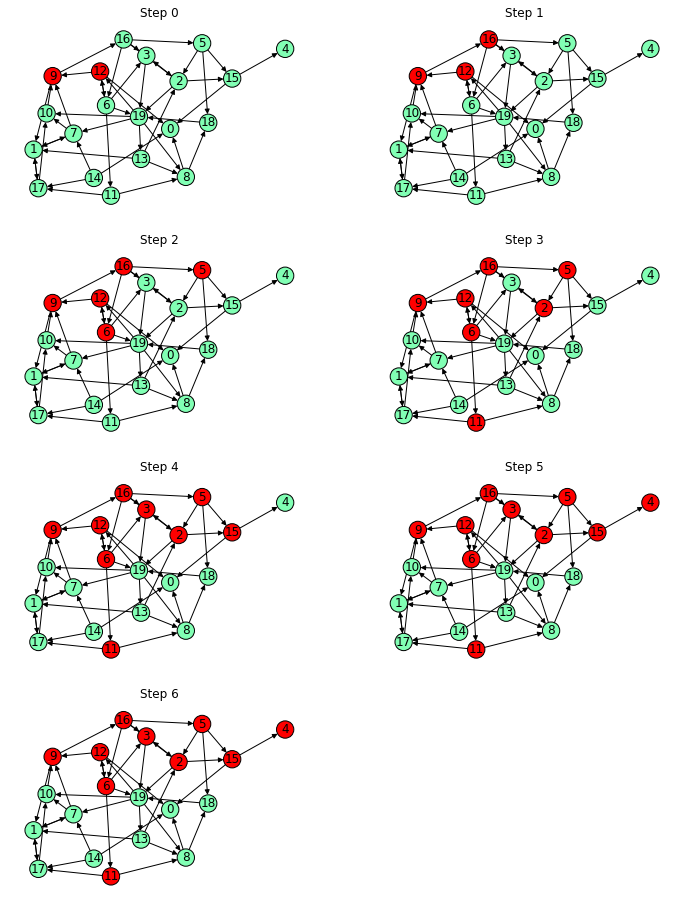

In [63]:
n = 20
G = nx.erdos_renyi_graph(n, 0.11, 0, True)

np.random.seed(5)
active_nodes = np.zeros(n, 'int')
active_nodes[np.random.choice(np.arange(n), 2, False)] = 1
thresholds = np.random.uniform(0.5, 1, n)

best_active = greedy_influence_max(G, thresholds, 2)
sim = linear_threshold(G, best_active, thresholds)

plt.figure(figsize=(6*2, 4*4))

for i, color in enumerate(sim):
    plt.subplot(4, 2, i+1)
    nx.draw(G, pos, with_labels=True, 
            node_color=color+1, 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    plt.title('Step {}'.format(i))
plt.show()